<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=162686937" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [1]:
# source
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
#!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
#import schedule
import warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# [Fear & Greed Index](https://www.cnn.com/markets/fear-and-greed)

In [3]:
!pip install fear-and-greed
clear_output()

import fear_and_greed
#type(fear_and_greed.get())

print('\nIndex: ',fear_and_greed.get()[0])
print('Range: ',fear_and_greed.get()[1])
print('Datetime: ',fear_and_greed.get()[2])

Index:  77.8857142857143

Range:  extreme greed

Datetime:  2024-02-12 23:59:43+00:00

# Today's Yahoo Gainers 
## Including Recommendations, Candlesticks, Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, Exponential Moving Averages (EMA) & Kalman Forecast Predictors. 
### This notebook only plots entry & exit stocks out of the 100 from Yahoo's Gainers webpage.

In [4]:
from datetime import datetime
today = pd.Timestamp(datetime.now(), tz='EST').strftime("%Y-%m-%d")
print(f"Calculating indicators for today's date: {today}.")

Calculating indicators for today's date: 2024-02-13.

# Entry Points

Entry Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: ARM

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 148.97000122070312

Ichimoku 9-Day Forecast: 115.95999908447266

Ichimoku 26-Day Forecast: 112.18499946594238

Choppiness (%): 17.95

RSI: 91.37952441160022

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

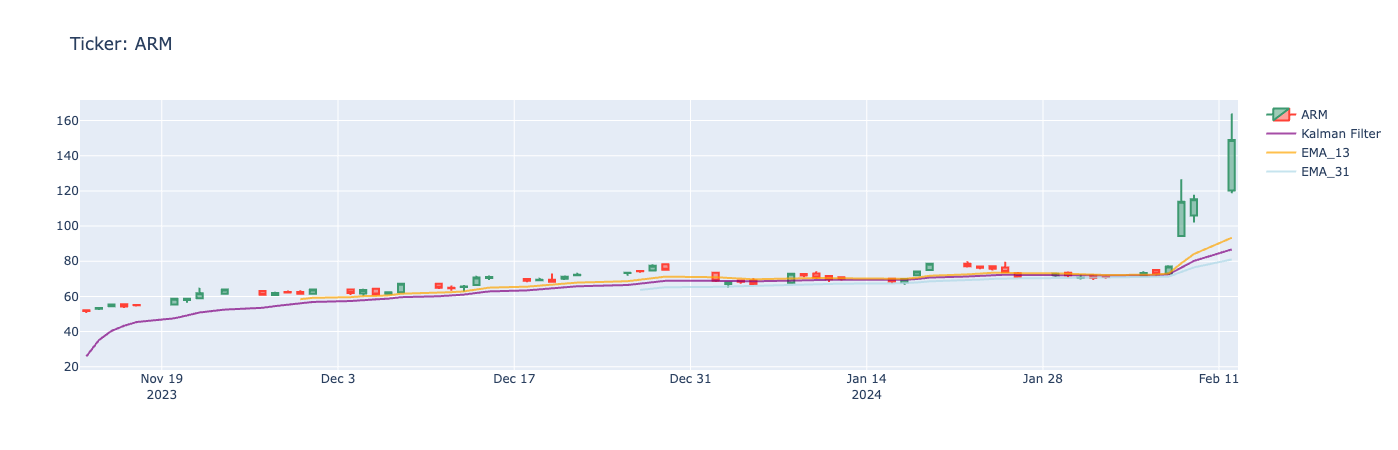

Ticker: CBAY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 32.209999084472656

Ichimoku 9-Day Forecast: 27.452500820159912

Ichimoku 26-Day Forecast: 24.855000495910645

Choppiness (%): 26.31

RSI: 83.37035756324222

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

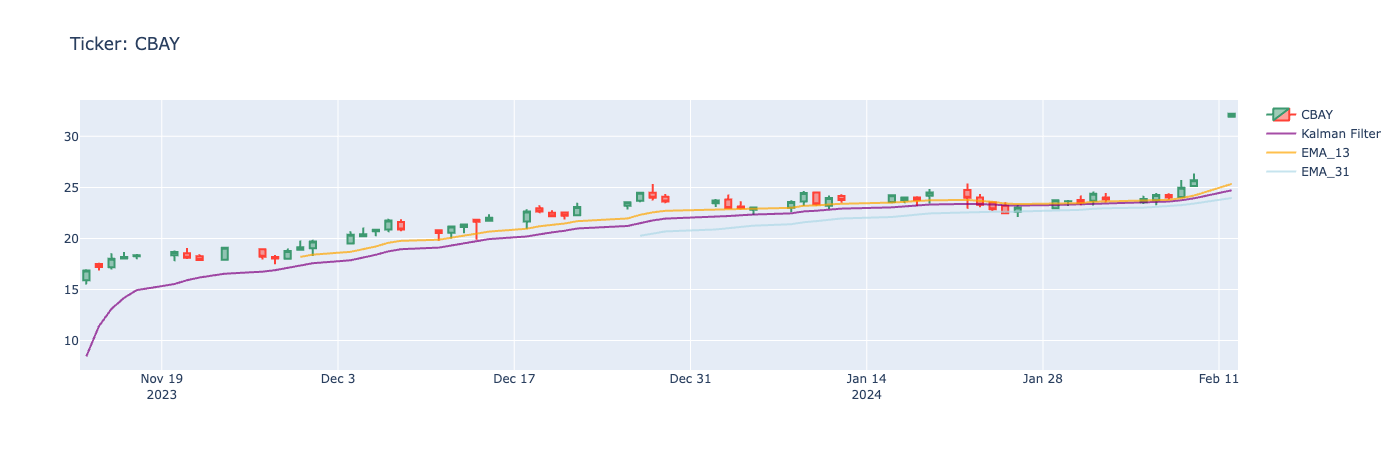

Ticker: CLSK

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 16.0049991607666

Ichimoku 9-Day Forecast: 11.732500195503235

Ichimoku 26-Day Forecast: 11.075000286102295

Choppiness (%): 22.13

RSI: 80.84037712308489

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

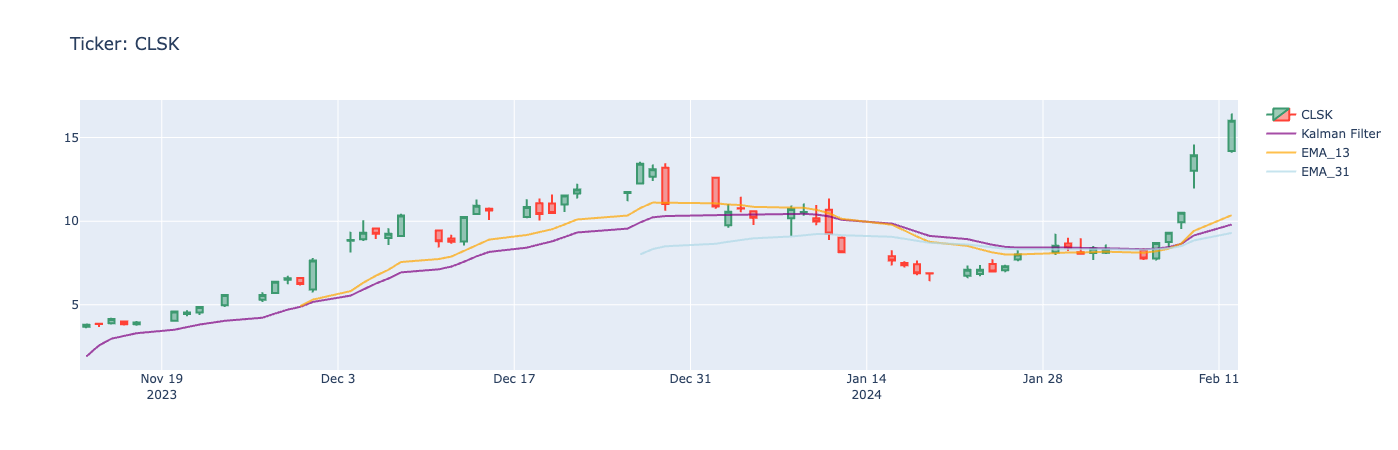

Ticker: MARA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 27.280000686645508

Ichimoku 9-Day Forecast: 21.872499704360962

Ichimoku 26-Day Forecast: 21.424999713897705

Choppiness (%): 32.32

RSI: 70.73019249400194

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

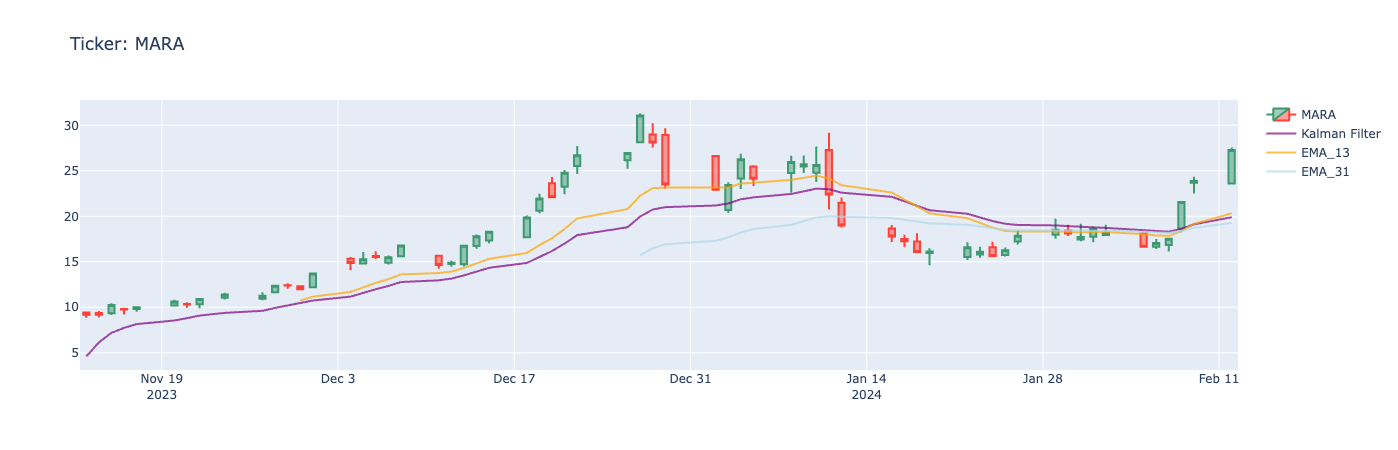

Ticker: MSTR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 717.52001953125

Ichimoku 9-Day Forecast: 589.1925048828125

Ichimoku 26-Day Forecast: 583.2550048828125

Choppiness (%): 21.82

RSI: 75.8663327533147

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

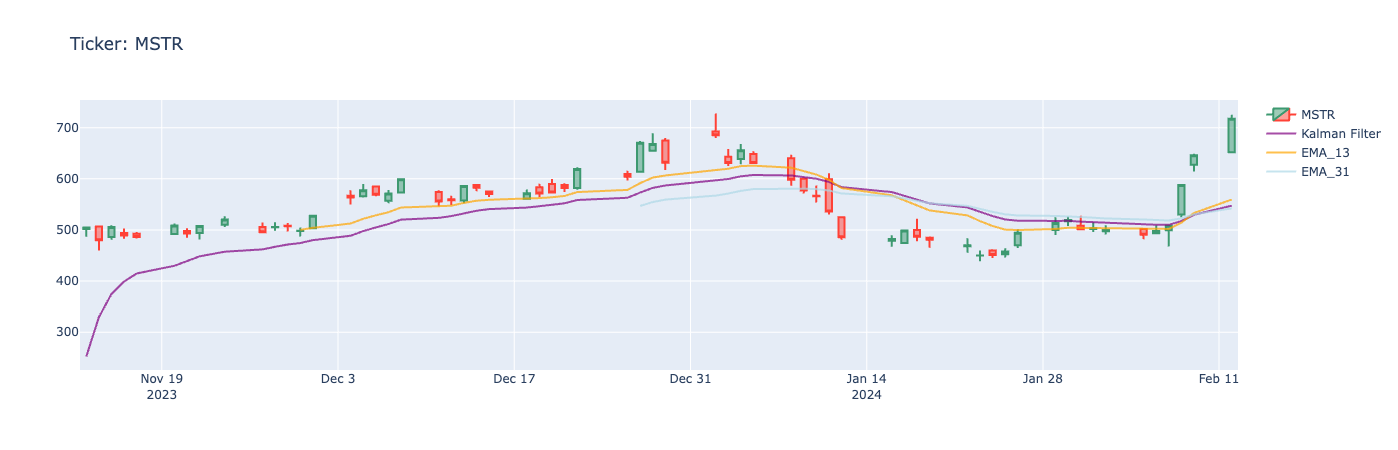

Ticker: SFTBY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 29.700000762939453

Ichimoku 9-Day Forecast: 25.59499979019165

Ichimoku 26-Day Forecast: 24.684999465942383

Choppiness (%): 26.88

RSI: 87.93014033322953

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

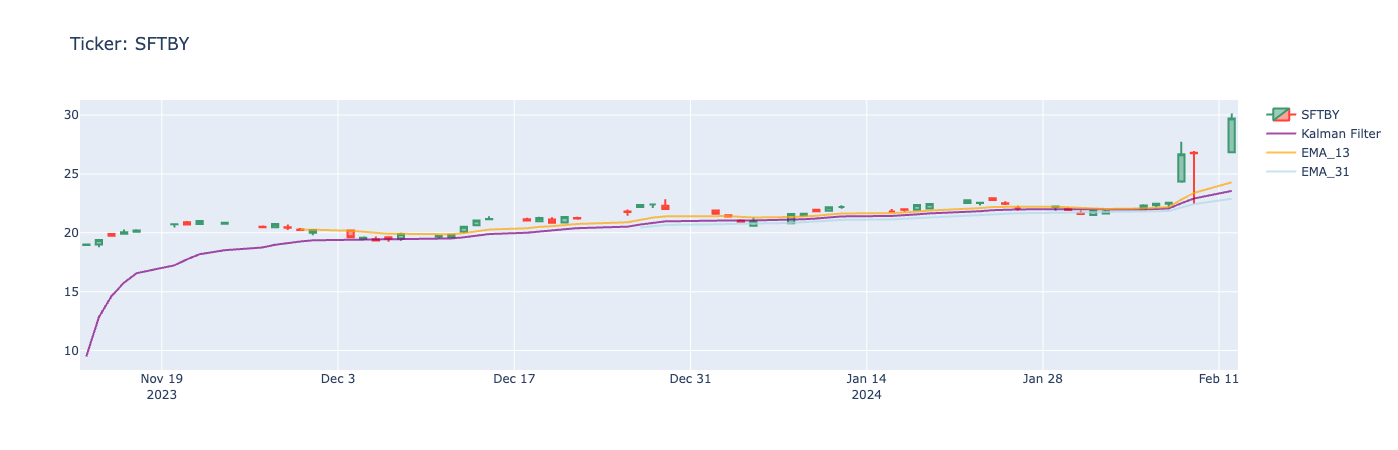

Ticker: SFTBF

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 59.5

Ichimoku 9-Day Forecast: 50.80000019073486

Ichimoku 26-Day Forecast: 49.19499969482422

Choppiness (%): 19.44

RSI: 85.5582153987729

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

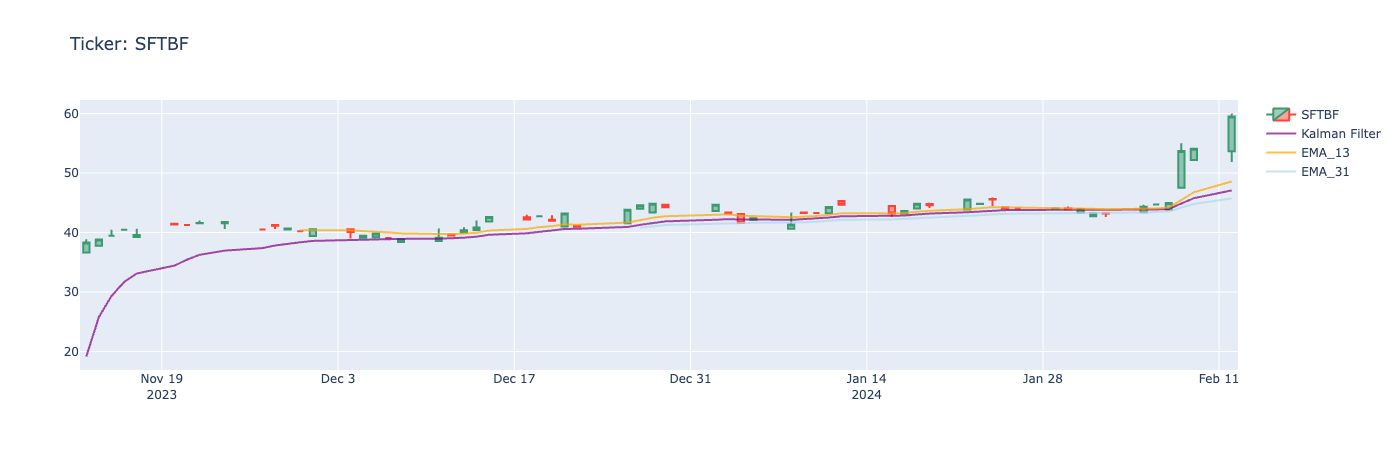

Ticker: AI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 31.18000030517578

Ichimoku 9-Day Forecast: 27.608749389648438

Ichimoku 26-Day Forecast: 28.744999885559082

Choppiness (%): 37.96

RSI: 68.37858930264952

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

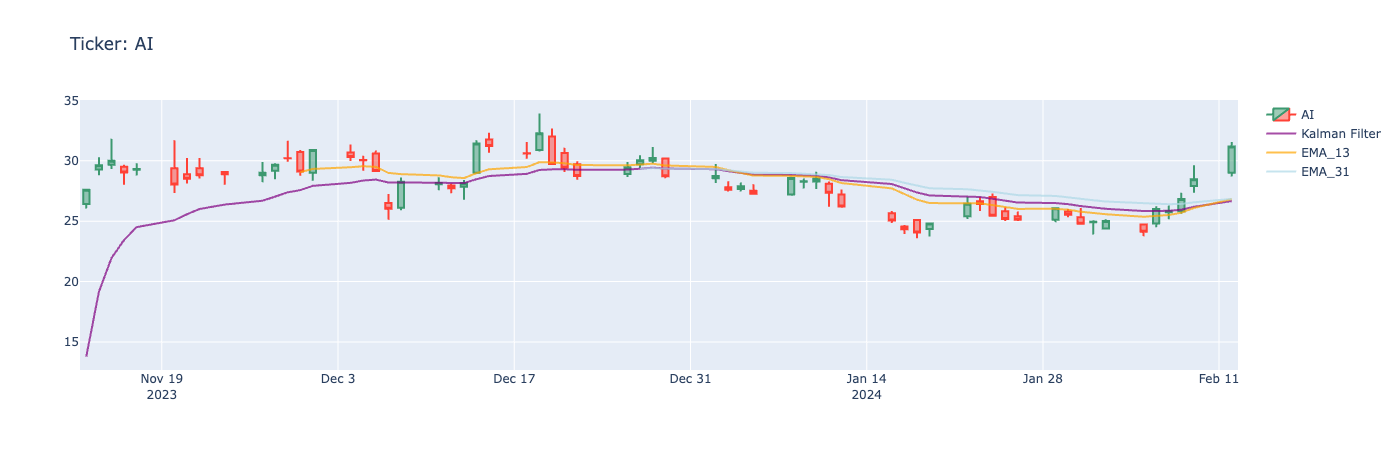

Ticker: RIOT

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 15.920000076293945

Ichimoku 9-Day Forecast: 13.31475019454956

Ichimoku 26-Day Forecast: 14.192500114440918

Choppiness (%): 29.55

RSI: 67.9056810313206

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

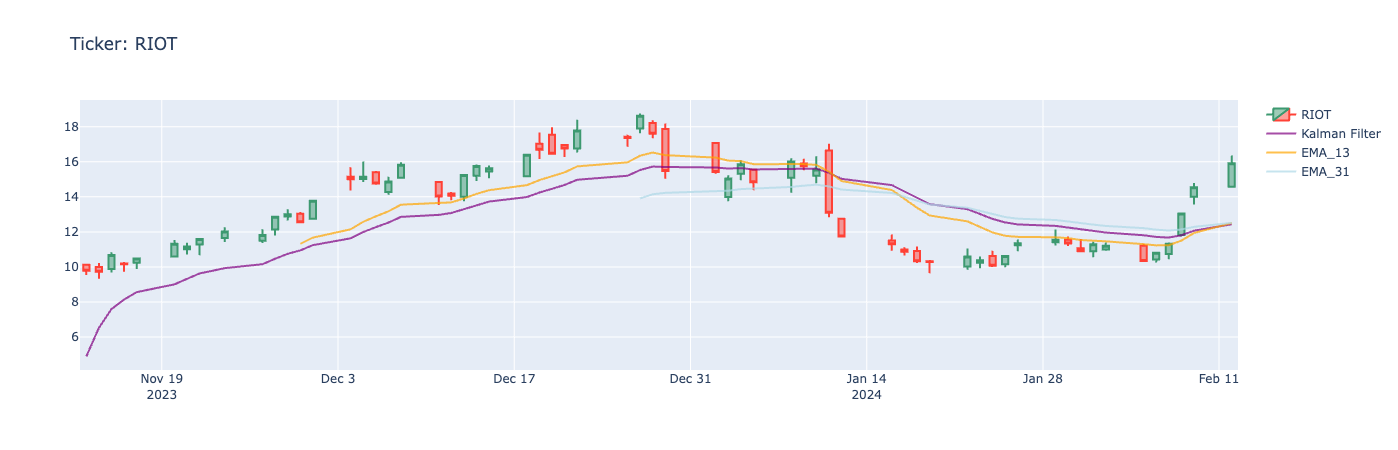

Ticker: FANG

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 165.97999572753906

Ichimoku 9-Day Forecast: 158.02499389648438

Ichimoku 26-Day Forecast: 156.90999603271484

Choppiness (%): 38.62

RSI: 68.69001858783142

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

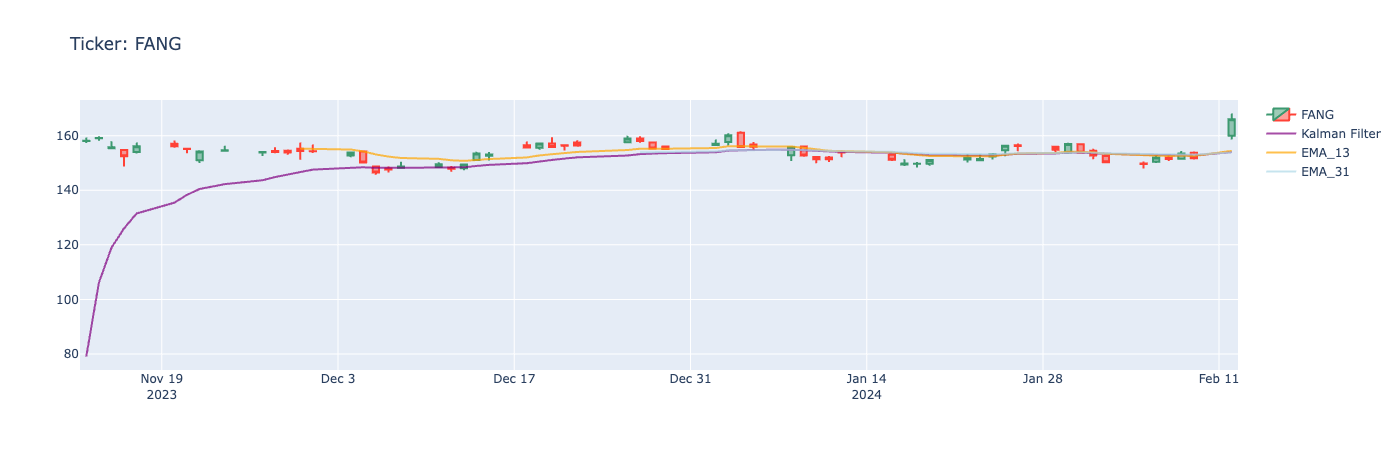

Ticker: BCKIF

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 6.090000152587891

Ichimoku 9-Day Forecast: 5.735000014305115

Ichimoku 26-Day Forecast: 5.430000066757202

Choppiness (%): 32.00

RSI: 73.27971798060909

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

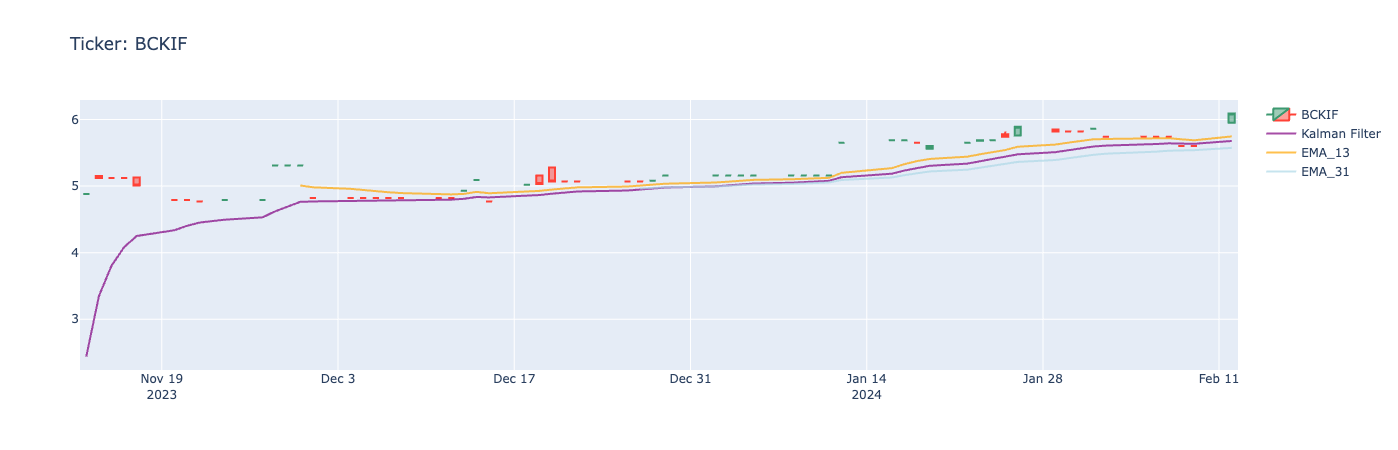

Ticker: MHK

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 117.23999786376953

Ichimoku 9-Day Forecast: 108.4275016784668

Ichimoku 26-Day Forecast: 100.47500228881836

Choppiness (%): 35.13

RSI: 74.84553190644998

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

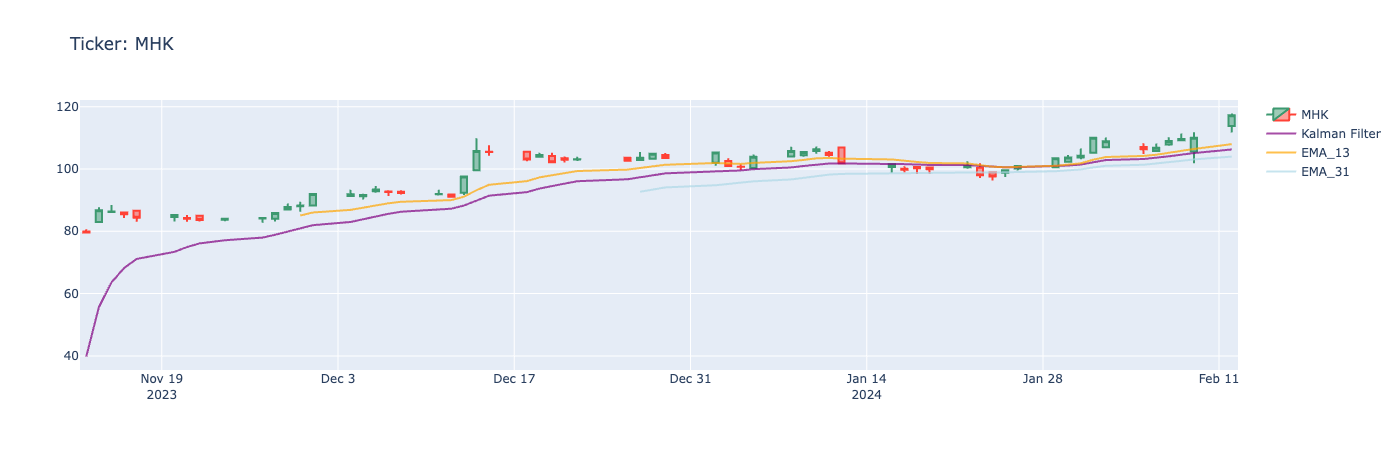

Ticker: RNMBY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 77.05000305175781

Ichimoku 9-Day Forecast: 72.3862476348877

Ichimoku 26-Day Forecast: 68.45599937438965

Choppiness (%): 36.06

RSI: 74.80399604362688

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

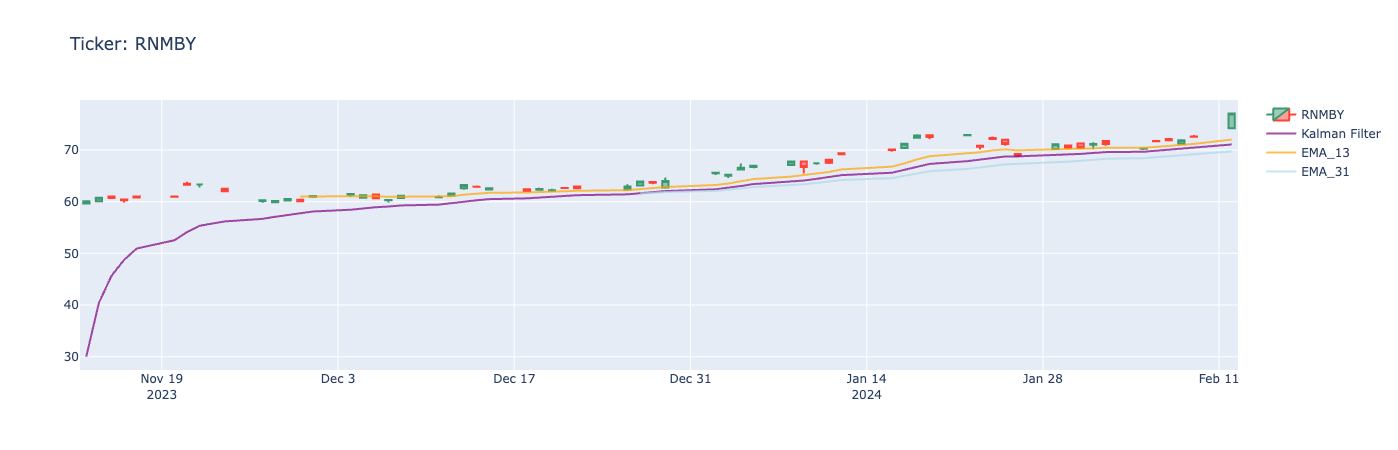

Ticker: CENTA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 38.11000061035156

Ichimoku 9-Day Forecast: 35.98299980163574

Ichimoku 26-Day Forecast: 33.86299991607666

Choppiness (%): 34.39

RSI: 73.10618431453035

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

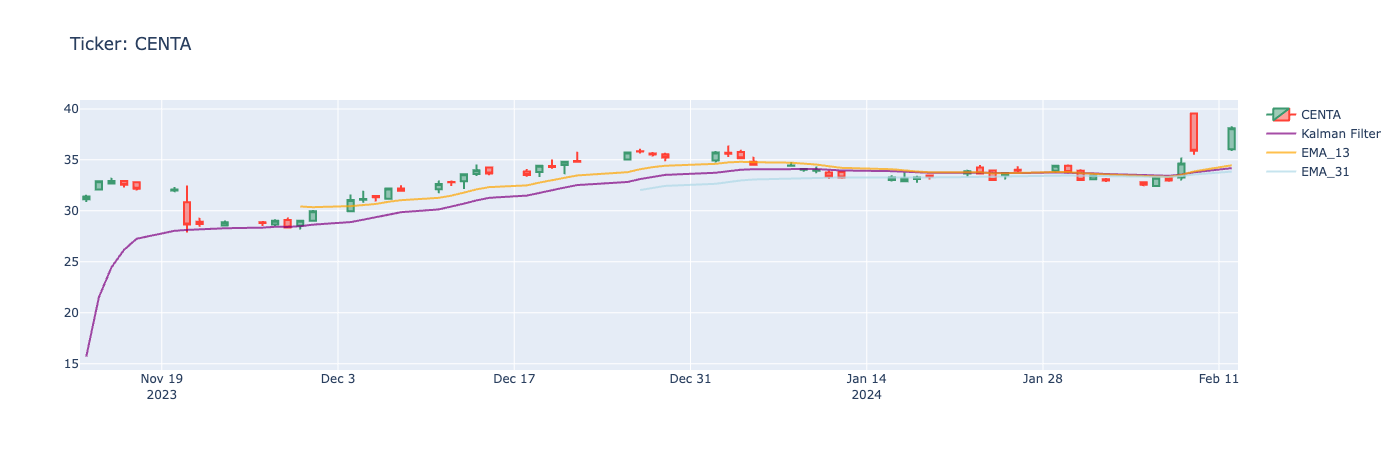

Ticker: ENPH

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 128.89999389648438

Ichimoku 9-Day Forecast: 113.20000076293945

Ichimoku 26-Day Forecast: 116.58499526977539

Choppiness (%): 39.55

RSI: 66.57245978969326

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

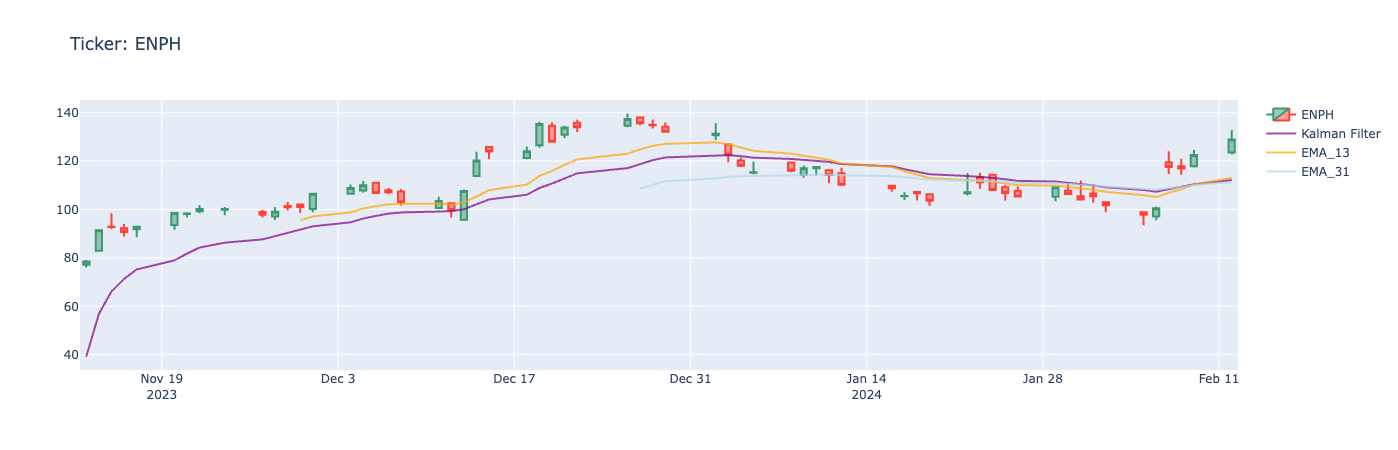

Ticker: CENT

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 43.349998474121094

Ichimoku 9-Day Forecast: 40.27903366088867

Ichimoku 26-Day Forecast: 37.549981117248535

Choppiness (%): 30.46

RSI: 75.8036128480744

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

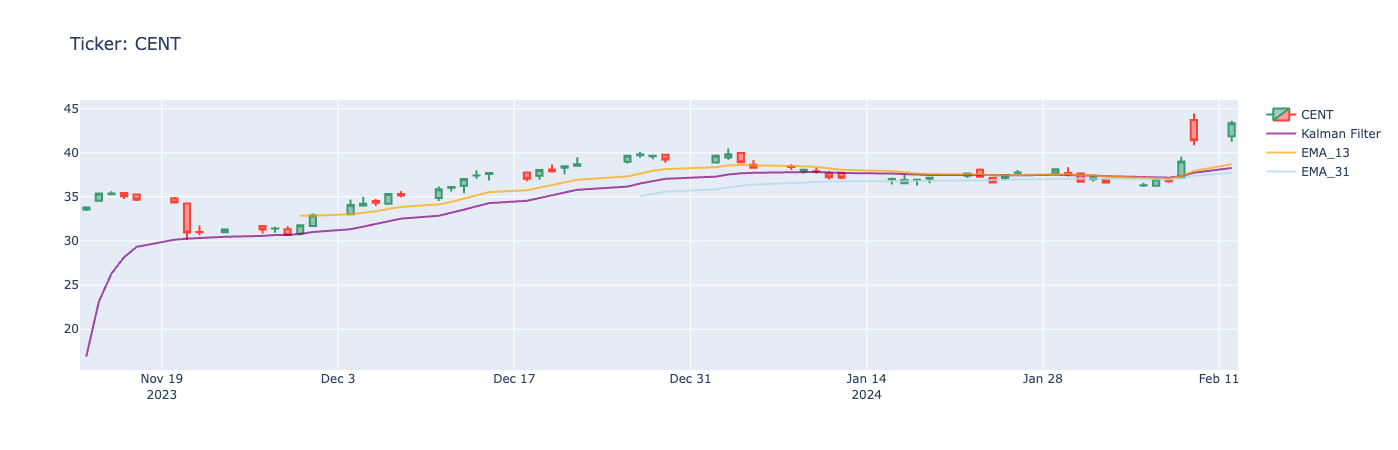

Ticker: HOEGF

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 12.699999809265137

Ichimoku 9-Day Forecast: 11.202500104904175

Ichimoku 26-Day Forecast: 10.394999980926514

Choppiness (%): 20.64

RSI: 79.73449591371143

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

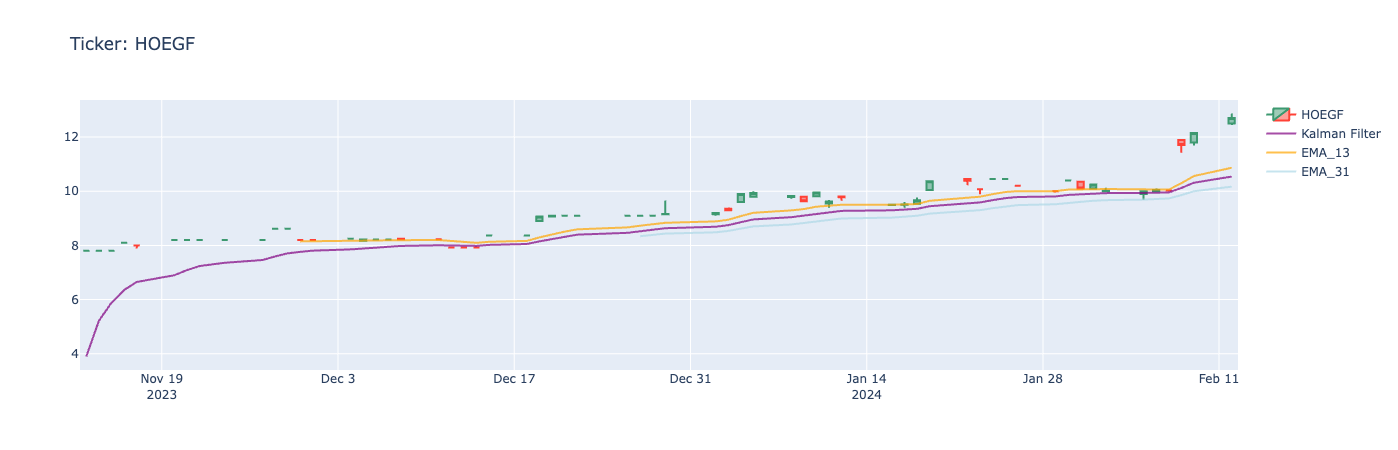

Ticker: SMCI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 773.010009765625

Ichimoku 9-Day Forecast: 602.7249984741211

Ichimoku 26-Day Forecast: 530.6449966430664

Choppiness (%): 24.03

RSI: 94.05416724946801

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

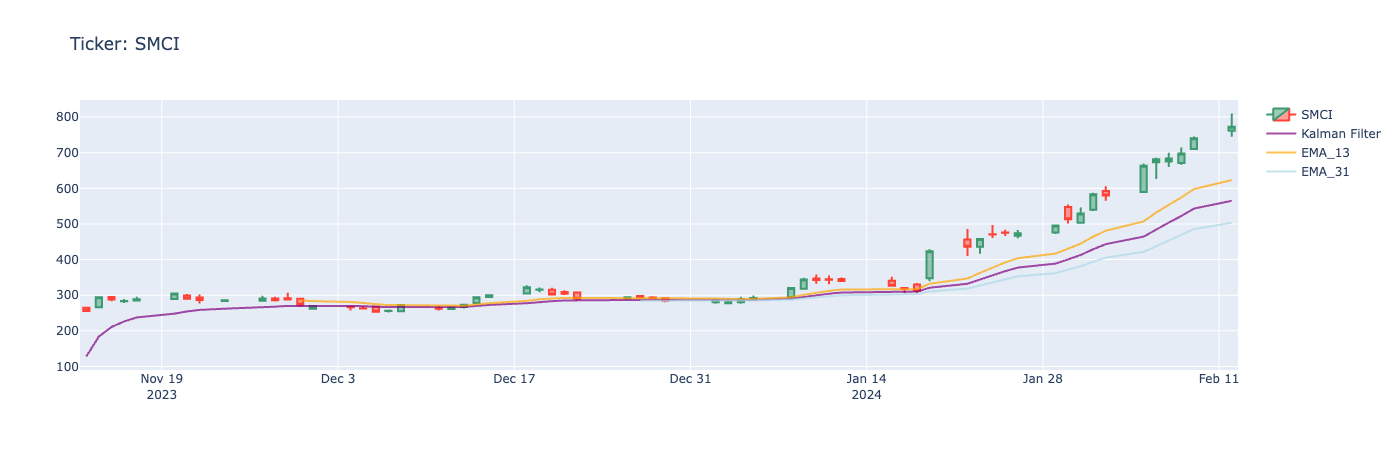

Ticker: VSCO

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 30.5

Ichimoku 9-Day Forecast: 27.389999389648438

Ichimoku 26-Day Forecast: 25.859999656677246

Choppiness (%): 37.19

RSI: 73.79725922222033

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

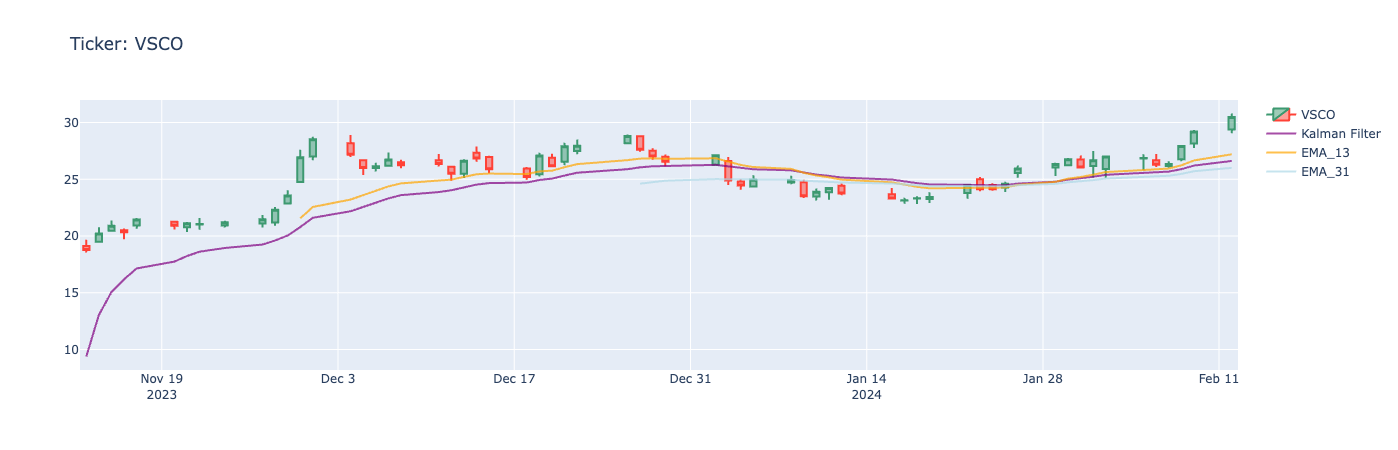

In [5]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers?count=100&offset=0'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
print('\n Entry Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if (calculate_symbol(v)[8] == True) & (calculate_symbol(v)[4]<="40"):
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Exit Points

Exit Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: UI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 128.57000732421875

Ichimoku 9-Day Forecast: 126.40999984741211

Ichimoku 26-Day Forecast: 127.05499649047852

Choppiness (%): 50.03

RSI: 50.72613120639871

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

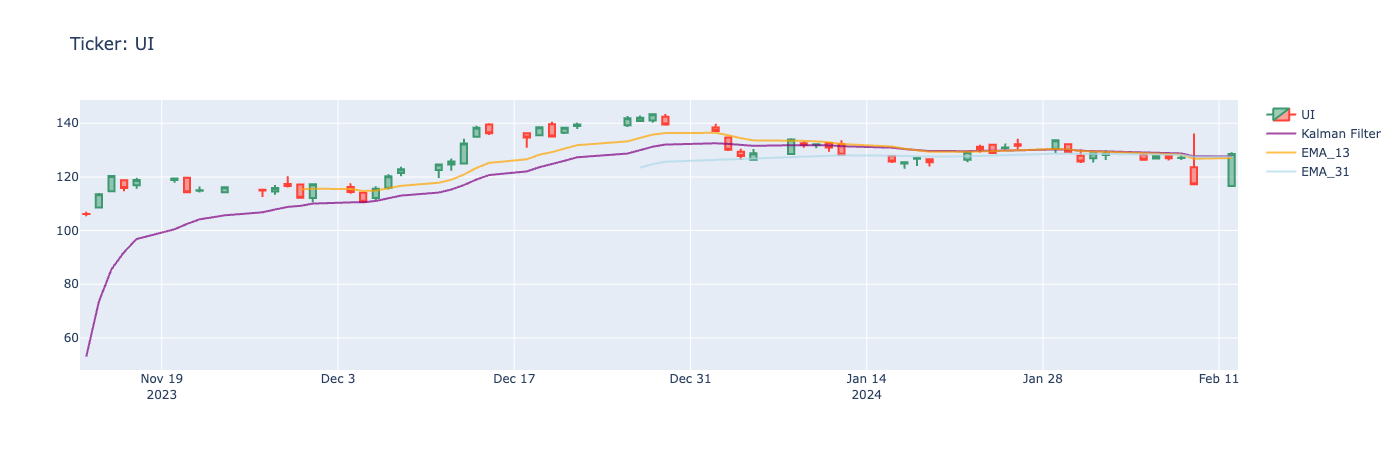

Ticker: KOS

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 5.78000020980835

Ichimoku 9-Day Forecast: 5.995000004768372

Ichimoku 26-Day Forecast: 6.215000152587891

Choppiness (%): 50.06

RSI: 41.80806945005848

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

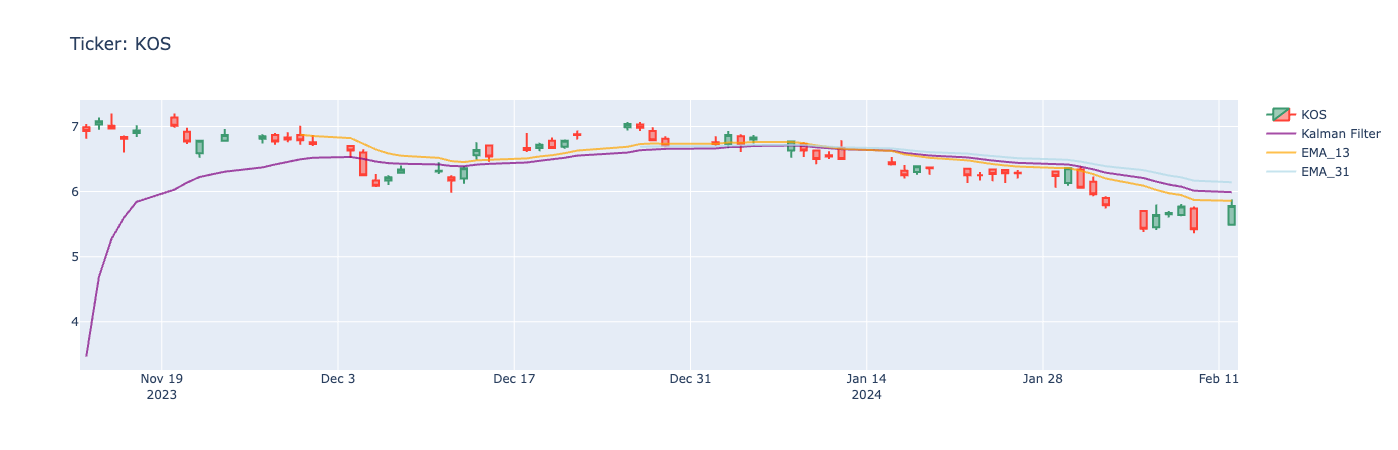

Ticker: MQ

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 6.099999904632568

Ichimoku 9-Day Forecast: 6.0950000286102295

Ichimoku 26-Day Forecast: 6.444999933242798

Choppiness (%): 57.34

RSI: 49.282987391066946

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

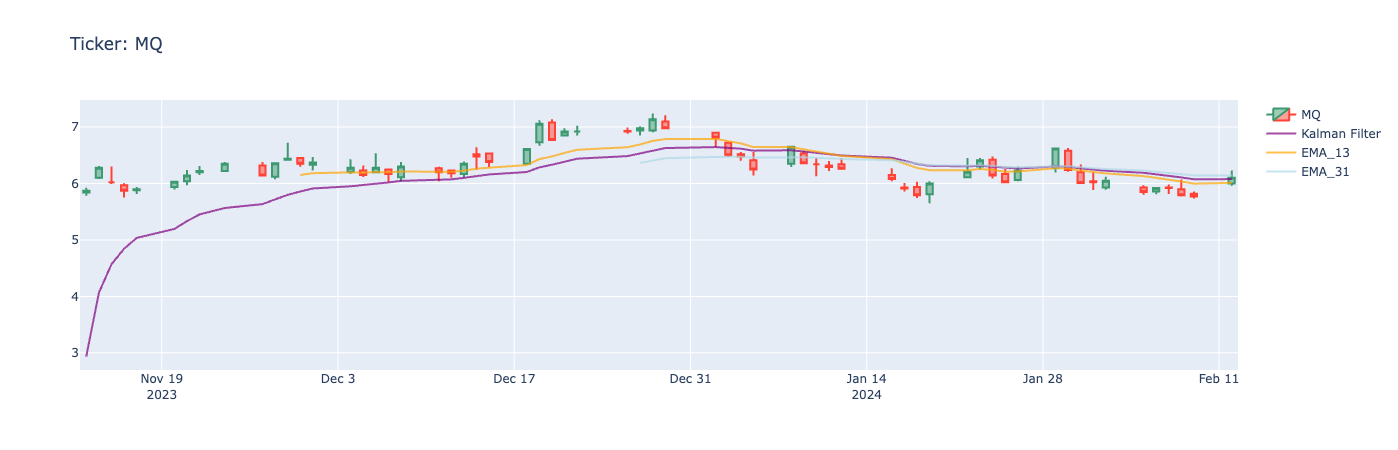

Ticker: RKT

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 12.100000381469727

Ichimoku 9-Day Forecast: 12.157500267028809

Ichimoku 26-Day Forecast: 12.125

Choppiness (%): 54.33

RSI: 49.4560094089729

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

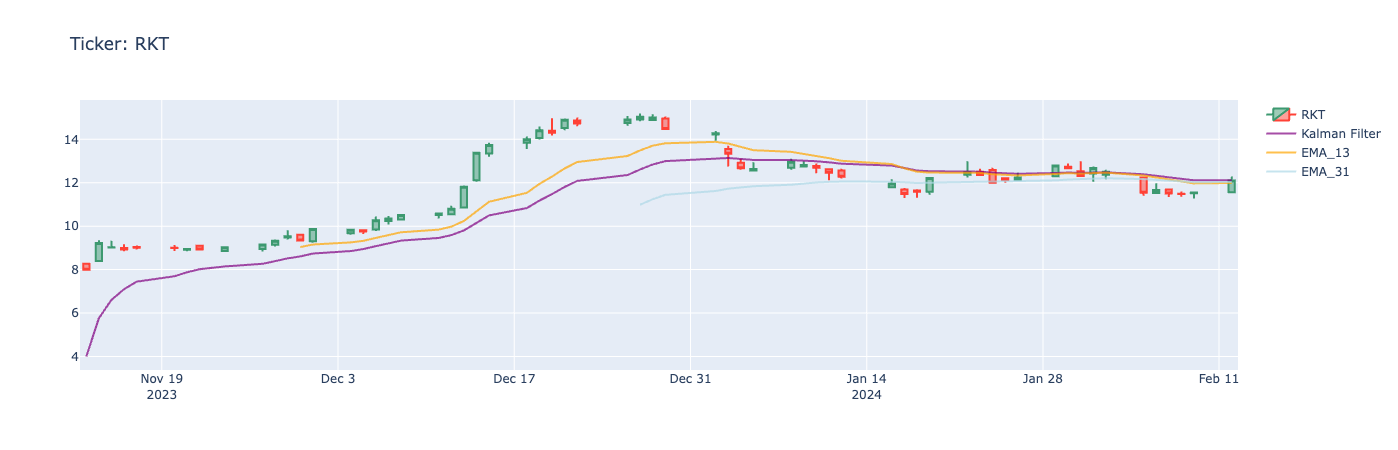

In [6]:
print('\n Exit Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if (calculate_symbol(v)[9] == True) & (calculate_symbol(v)[4] >= "50"):
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Portfolio

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Ticker: AAPL

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 187.14999389648438

Ichimoku 9-Day Forecast: 186.48250198364258

Ichimoku 26-Day Forecast: 189.43499755859375

Choppiness (%): 36.36

RSI: 45.68866020302271

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

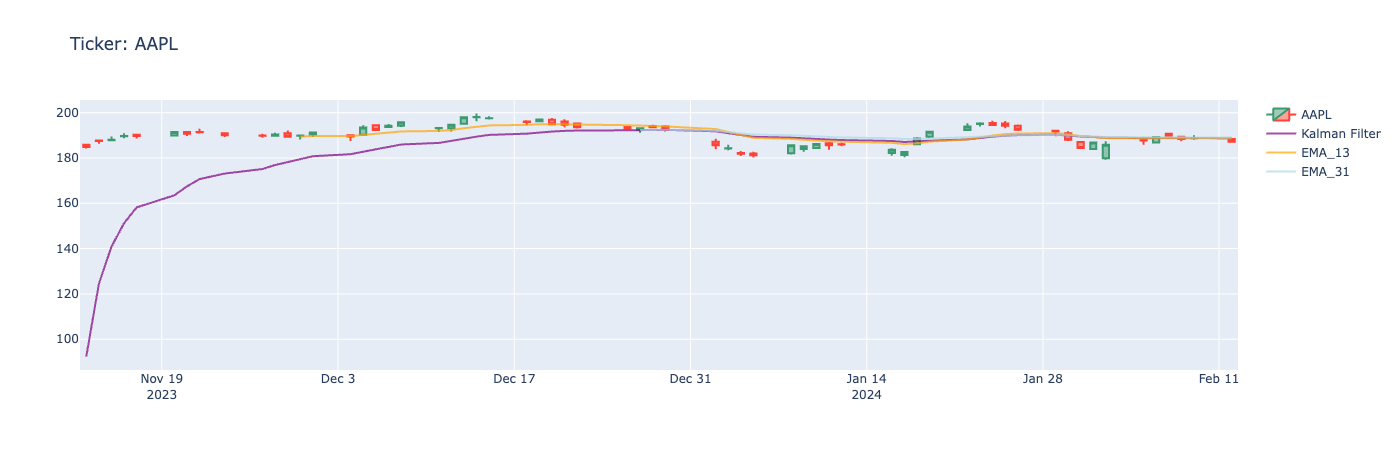

Ticker: AI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 31.18000030517578

Ichimoku 9-Day Forecast: 27.608749389648438

Ichimoku 26-Day Forecast: 28.744999885559082

Choppiness (%): 37.96

RSI: 68.37858930264952

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

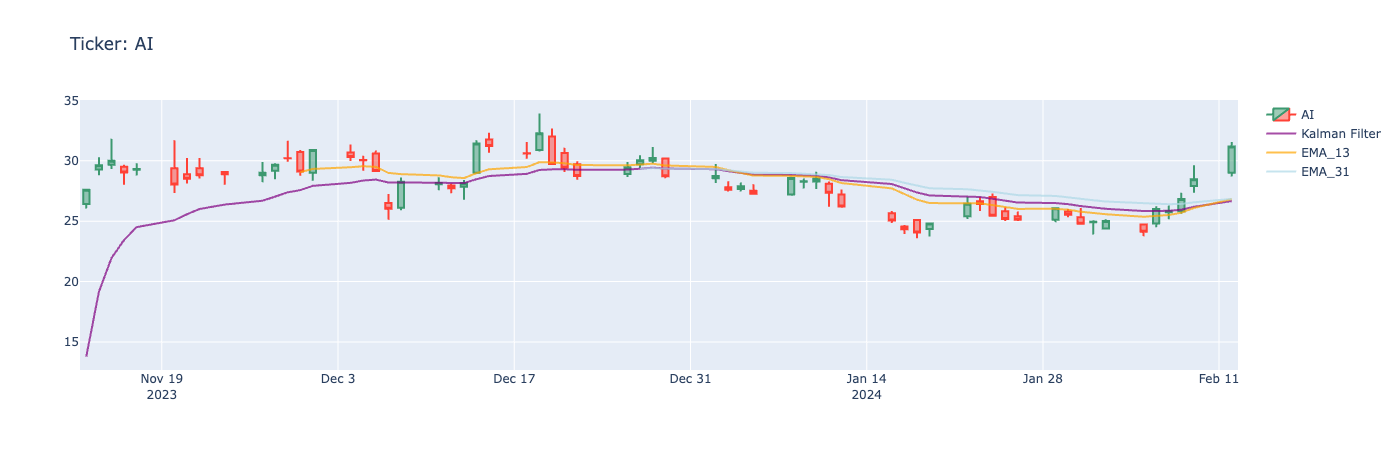

Ticker: FCEL

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 1.5

Ichimoku 9-Day Forecast: 1.3199999928474426

Ichimoku 26-Day Forecast: 1.465000033378601

Choppiness (%): 51.75

RSI: 63.919065501112684

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

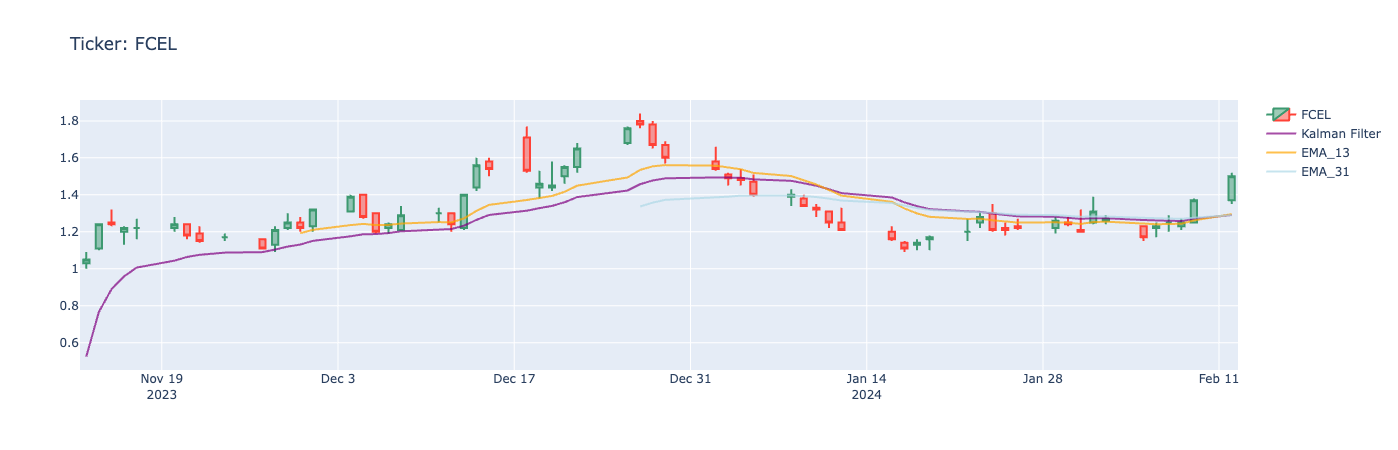

Ticker: FSR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 0.7900000214576721

Ichimoku 9-Day Forecast: 0.9500000178813934

Ichimoku 26-Day Forecast: 1.350000023841858

Choppiness (%): 62.05

RSI: 37.1842979409605

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

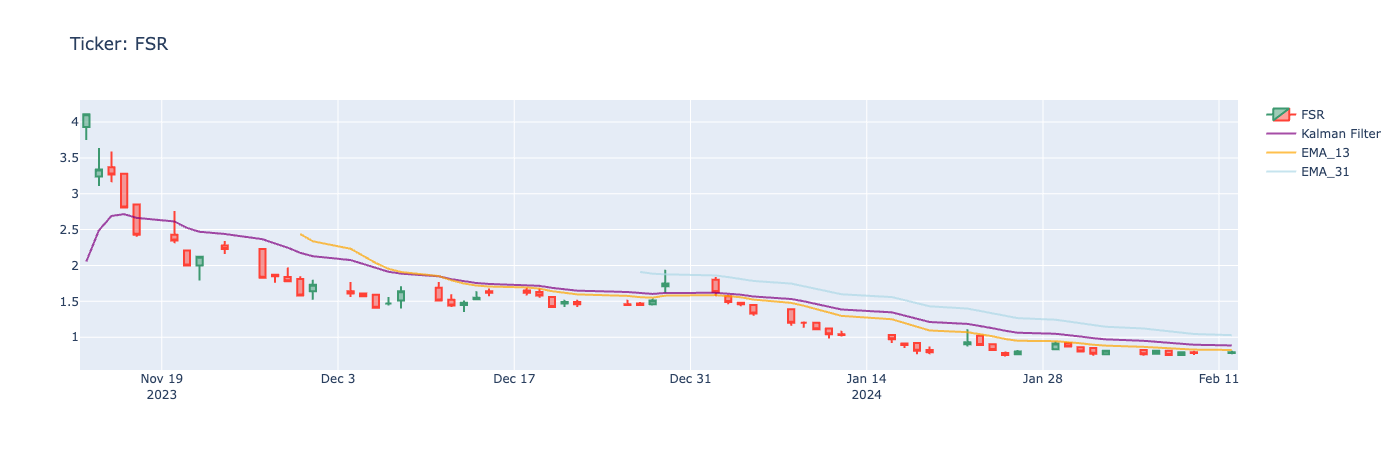

Ticker: NOC

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 451.4700012207031

Ichimoku 9-Day Forecast: 451.1949996948242

Ichimoku 26-Day Forecast: 456.1999969482422

Choppiness (%): 36.55

RSI: 45.78624500583616

Archer MA Trending: True

EMA_13 > Kalman: False

Low > Kalman: False

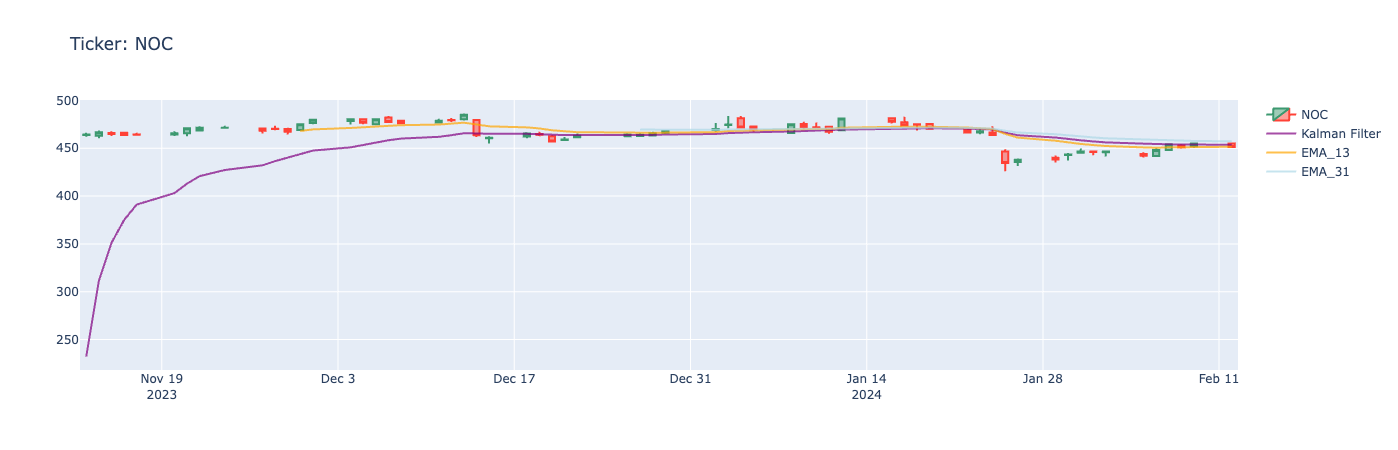

Ticker: PLTR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 25.049999237060547

Ichimoku 9-Day Forecast: 20.685999870300293

Ichimoku 26-Day Forecast: 20.594499588012695

Choppiness (%): 27.66

RSI: 80.67043471838899

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

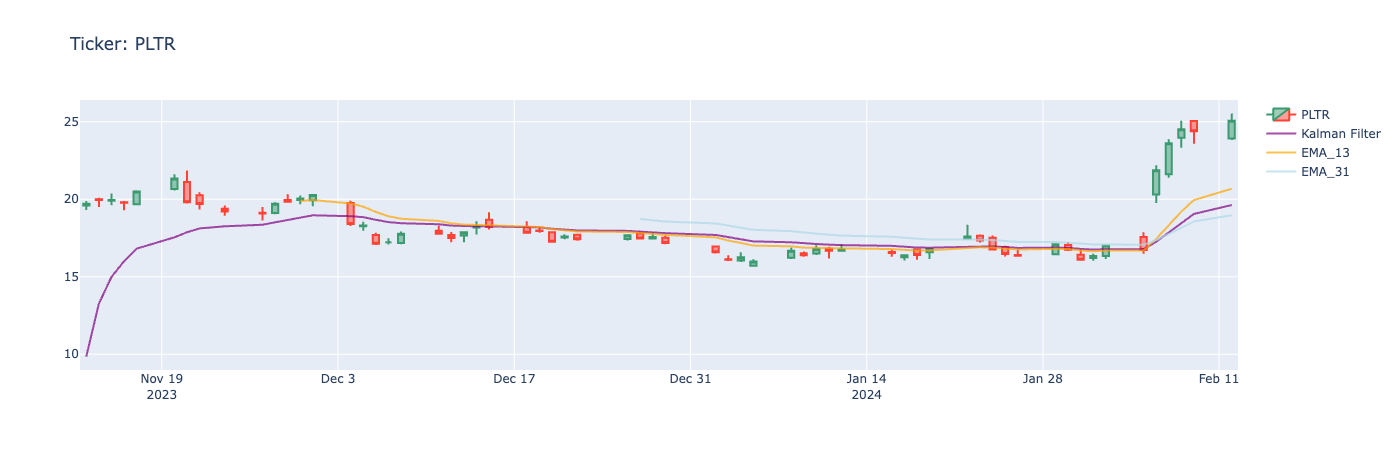

Ticker: SBUX

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 95.47000122070312

Ichimoku 9-Day Forecast: 94.94750022888184

Ichimoku 26-Day Forecast: 96.72500228881836

Choppiness (%): 55.21

RSI: 53.98204206221455

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

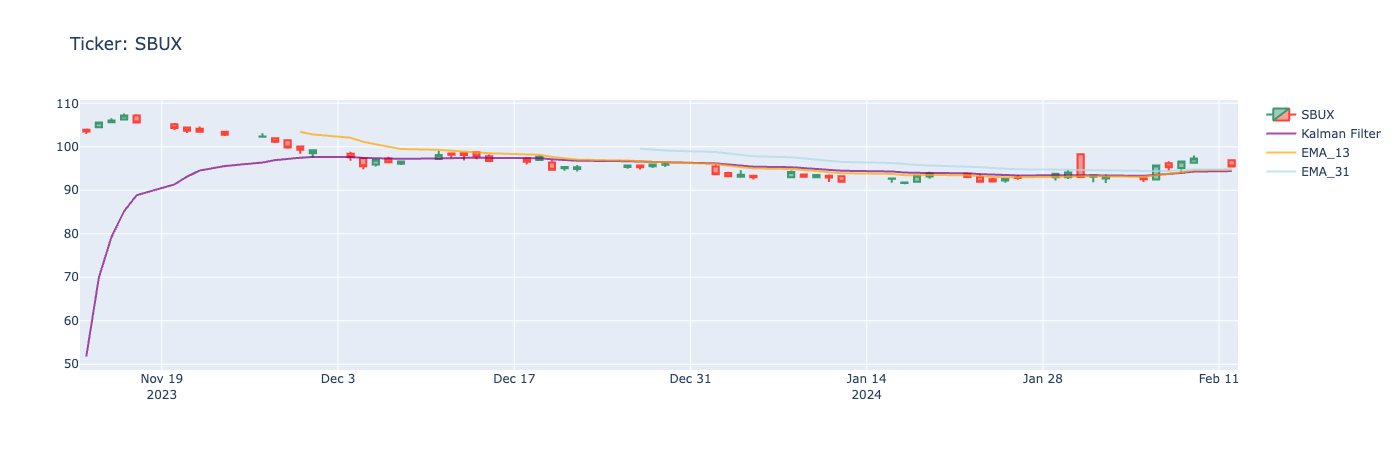

Ticker: TSLA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 188.1300048828125

Ichimoku 9-Day Forecast: 196.49999618530273

Ichimoku 26-Day Forecast: 220.06999969482422

Choppiness (%): 44.01

RSI: 35.60068876046041

Archer MA Trending: True

EMA_13 > Kalman: False

Low > Kalman: False

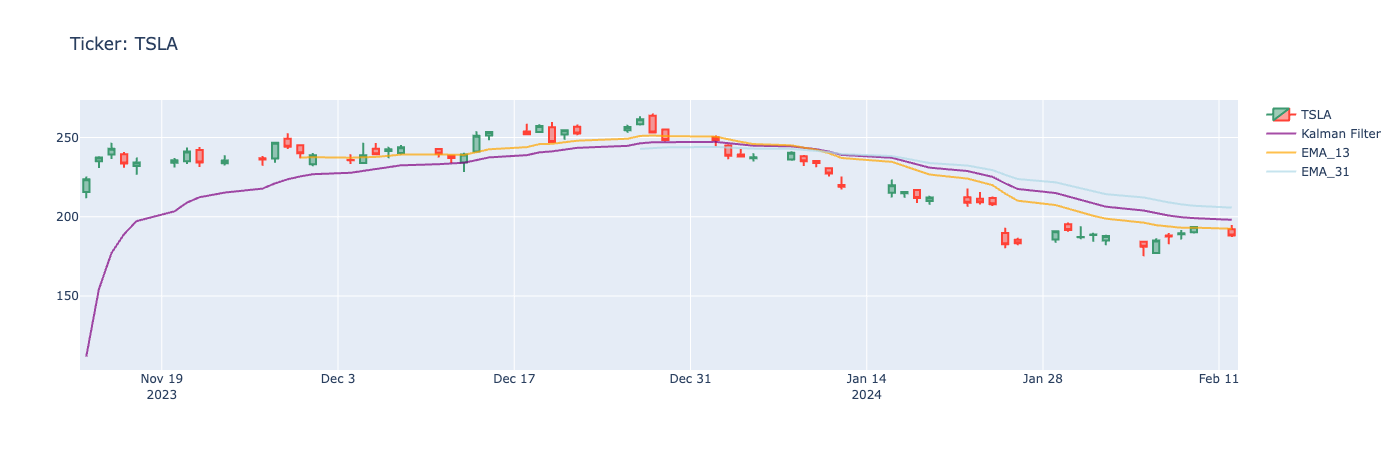

In [7]:
# calculating plotter
Portfolio = ['AAPL','AI','FCEL','FSR','NOC','PLTR','SBUX','TSLA']
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for v in Portfolio]: 
    print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40):',calculate_symbol(v)[8])
    print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
    print('\n\nClose:',calculate_symbol(v)[1])
    print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
    print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
    print('Choppiness (%):',calculate_symbol(v)[4])
    print('RSI:',calculate_symbol(v)[5])
    print('Archer MA Trending:',calculate_symbol(v)[6])
    print('EMA_13 > Kalman:',calculate_symbol(v)[7])
    print('Low > Kalman:',calculate_symbol(v)[10])
    plot(v.tail(90),i)
else:pass

In [8]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [9]:
# soon to incorporate this charting method: https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

In [10]:
# en fin

# Disclaimer

All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. We will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.


# Supplementary

[*********************100%%**********************]  1 of 1 completed


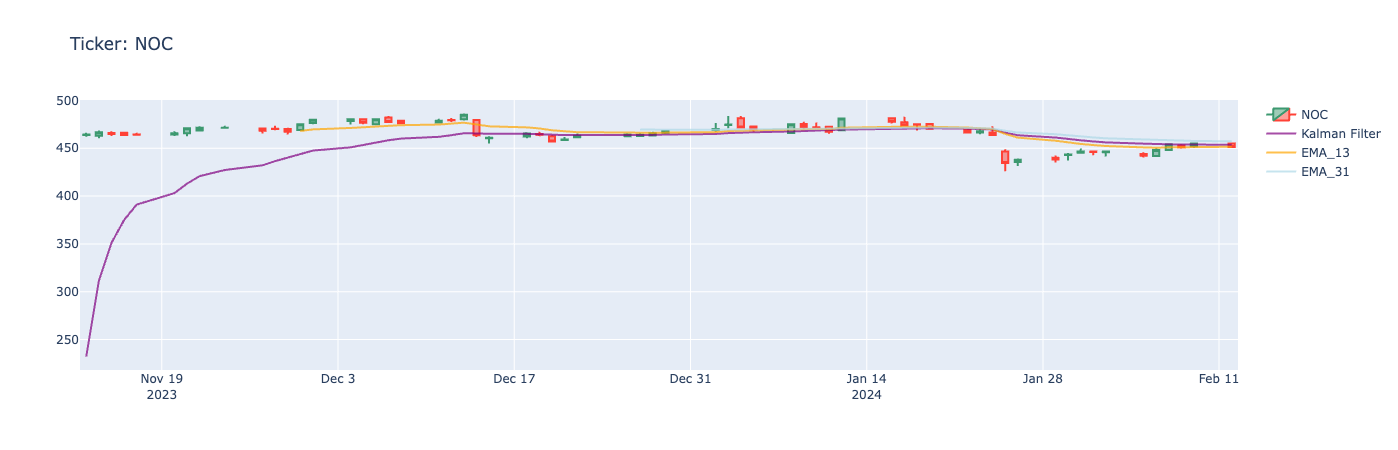

In [11]:
ticker = 'NOC'
df = yf.download(tickers=ticker, period='3mo', interval='1d')
calculate_symbol(df)
plot(df,ticker)


In [12]:
# Used for example Trend Return Long Trend Below
macd_ = ta.macd(df.Close)
macdh = macd_[macd_.columns[1]]
df.tail()

,Open,High,Low,Close,Adj Close,Volume,close,low,high,open,kf_mean,EMA_13,EMA_31,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0
Date,,,,,,,,,,,,,,,,,,
2024-02-06,442.000000,449.920013,440.940002,448.170013,448.170013,587900,448.170013,440.940002,449.920013,442.000000,454.221976,450.553495,458.611011,425.678357,451.992859,478.307361,11.643769,0.427362
2024-02-07,448.170013,453.929993,448.170013,453.899994,453.899994,748100,453.899994,448.170013,453.929993,448.170013,454.191347,451.031566,458.316572,427.310622,450.512144,473.713666,10.300065,0.573009
2024-02-08,452.859985,454.149994,449.809998,451.220001,451.220001,527800,451.220001,449.809998,454.149994,452.859985,453.908695,451.058485,457.873036,428.716717,449.136429,469.556141,9.092877,0.551019
2024-02-09,452.109985,455.559998,450.519989,454.920013,454.920013,906700,454.920013,450.519989,455.559998,452.109985,454.004898,451.610132,457.688472,429.959715,448.300716,466.641717,8.182455,0.680451
2024-02-12,455.000000,455.640015,451.309998,451.470001,451.470001,723400,451.470001,451.309998,455.640015,455.000000,453.763764,451.590113,457.299818,432.166992,447.125715,462.084438,6.691059,0.645209


<Axes: title={'center': 'NOC'}, xlabel='Date'>

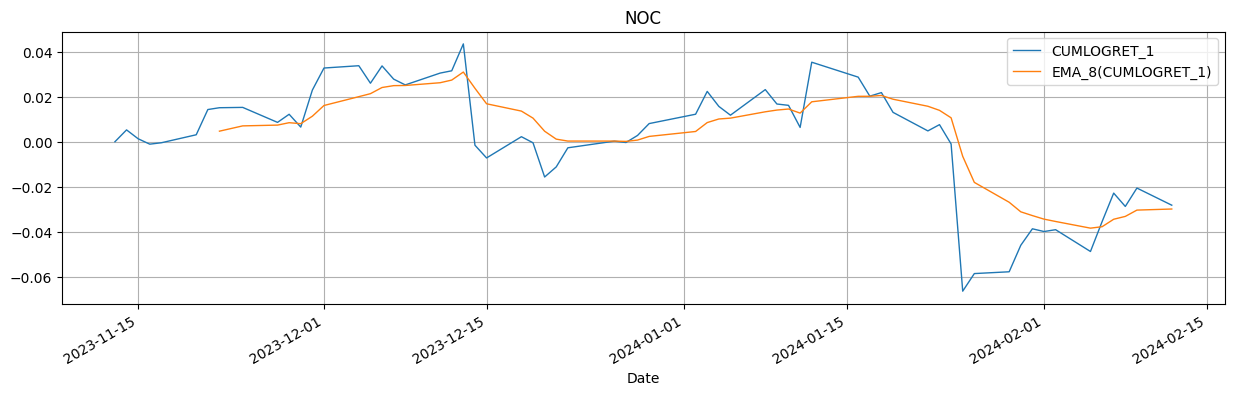

In [13]:
# cumulative log return
clr_ma_length = 8
clrdf = df.ta.log_return(cumulative=True, append=True)
clrmadf = ta.ema(clrdf, length=clr_ma_length)
clrxdf = pd.DataFrame({f"{clrdf.name}": clrdf, f"{clrmadf.name}({clrdf.name})": clrmadf})
clrxdf.plot(figsize=(15,4), linewidth=1, title=f"{ticker}", grid=True)

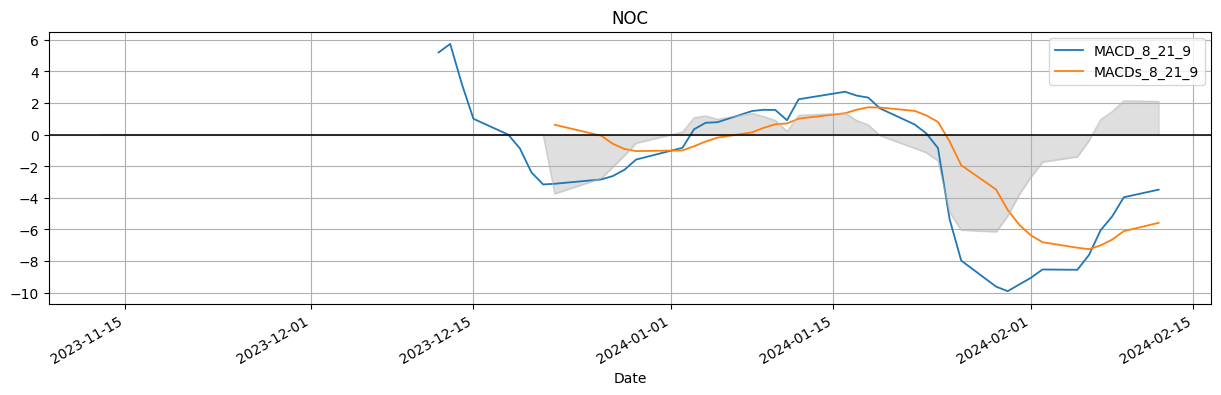

In [14]:
# macd
macddf = df.ta.macd(fast=8, slow=21, signal=9, min_periods=None, append=True)
macddf[[macddf.columns[0], macddf.columns[2]]].plot(figsize=(16, 2), linewidth=1.3)
macddf[macddf.columns[1]].plot.area(figsize=(15,4), stacked=False, color=["silver"], linewidth=1, title=f"{ticker}", grid=True).axhline(y=0, color="black", lw=1.1)